# Hierarchical clustering

## Setup

In [78]:
#| default_exp clustering

In [79]:
#| export
import pandas as pd,numpy as np
from katlas.data import *
from katlas.pssm import *
from katlas.plot import set_sns
from tqdm import tqdm
from functools import partial
from tqdm.contrib.concurrent import process_map
from fastcore.meta import delegates
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram
from matplotlib import pyplot as plt

In [80]:
#| hide
#| export
EPSILON = 1e-8

## KL divergence

In [81]:
#| export
def kl_divergence(p1,  # target pssm p (array-like, shape: (AA, positions))
                  p2,  # pred pssm q (array-like, same shape as p1)
                  mean=True):
    """
    KL divergence D_KL(p1 || p2) over positions.
    
    p1 and p2 are arrays (df or np) with index as aa and column as position.
    Returns average divergence across positions if mean=True, else per-position.
    """
    assert p1.shape == p2.shape
    
    # Mask invalid positions (both zero)
    valid = (p1 + p2) > 0
    p1 = np.where(valid, p1, 0.0)
    p2 = np.where(valid, p2, 0.0)

    # KL divergence: sum_x p1(x) log(p1(x)/p2(x))
    kl = np.sum(p1 * np.log((p1 + EPSILON) / (p2 + EPSILON)), axis=0)

    return float(kl.mean()) if mean else kl

The Kullback–Leibler (KL) divergence between two probability distributions \( P \) and \( Q \) is defined as:

$$
\mathrm{KL}(P \| Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x)}{Q(x)} \right)
$$

This measures the information lost when \( Q \) is used to approximate \( P \). It is **not symmetric**, i.e.,

$$
\mathrm{KL}(P \| Q) \ne \mathrm{KL}(Q \| P)
$$

and it is **non-negative**, meaning:

$$
\mathrm{KL}(P \| Q) \ge 0
$$

with equality if and only if \( P = Q \) almost everywhere.

In practical computation, to avoid numerical instability when \( P(x) = 0 \) or \( Q(x) = 0 \), we often add a small constant \( \varepsilon \):

$$
\mathrm{KL}_\varepsilon(P \| Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x) + \varepsilon}{Q(x) + \varepsilon} \right)
$$

In [82]:
pssms = Data.get_pspa_all_scale()

In [83]:
pssm_df.shape

(23, 10)

In [84]:
# one example
pssm_df = recover_pssm(pssms.iloc[1])
pssm_df2 = recover_pssm(pssms.iloc[0])

In [87]:
kl_divergence(pssm_df,pssm_df2,mean=True)

0.3724275257321628

In [88]:
#| export
def kl_divergence_flat(p1_flat, # pd.Series of target flattened pssm p
                       p2_flat, # pd.Series of pred flattened pssm q
                       ):

    "p1 and p2 are two flattened pd.Series with index as aa and column as position"
    kld = kl_divergence(p1_flat,p2_flat,mean=False) # do not do js.mean() because it's 1d
    total_position = len(p1_flat.index.str.extract(r'(-?\d+)').drop_duplicates())
    return float(kld/total_position)

In [89]:
%%time
kl_divergence_flat(pssms.iloc[1],pssms.iloc[0])

CPU times: user 2.83 ms, sys: 322 μs, total: 3.15 ms
Wall time: 3.21 ms


0.37242752573216287

## JS divergence

In [65]:
#| export
def js_divergence(p1, # pssm 
                  p2, # pssm
                  mean=True):
    "p1 and p2 are two arrays (df or np) with index as aa and column as position"
    assert p1.shape==p2.shape
    valid = (p1 + p2) > 0
    p1 = np.where(valid, p1, 0.0)
    p2 = np.where(valid, p2, 0.0)
    
    m = 0.5 * (p1 + p2)
    
    js = 0.5 * np.sum(p1 * np.log((p1+ EPSILON) / (m + EPSILON)), axis=0) + \
         0.5 * np.sum(p2 * np.log((p2+ EPSILON) / (m + EPSILON)), axis=0)
    return float(js.mean()) if mean else js

The Jensen-Shannon divergence between two probability distributions $ P $ and $ Q $ is defined as:

$$
\mathrm{JS}(P \| Q) = \frac{1}{2} \, \mathrm{KL}(P \| M) + \frac{1}{2} \, \mathrm{KL}(Q \| M)
$$

where $ M = \frac{1}{2}(P + Q) $ is the average (mixture) distribution, and $ \mathrm{KL} $ denotes the Kullback–Leibler divergence:

$$
\mathrm{KL}(P \| Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x)}{Q(x)} \right)
$$

Therefore,

$$
\mathrm{JS}_\varepsilon(P \| Q) = \frac{1}{2} \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x) + \varepsilon}{M(x) + \varepsilon} \right)
+ \frac{1}{2} \sum_{x \in \mathcal{X}} Q(x) \log \left( \frac{Q(x) + \varepsilon}{M(x) + \varepsilon} \right)
$$

In [57]:
js_divergence(pssm_df,pssm_df2)

0.08286124552178498

In [75]:
js_divergence(pssm_df,pssm_df)

0.0

In [76]:
# don't use it for flattend version, as it won't divide the total position
js_divergence(pssms.iloc[1],pssms.iloc[0])

0.8286124552178498

In [67]:
#| export
def js_divergence_flat(p1_flat, # pd.Series of flattened pssm
                       p2_flat, # pd.Series of flattened pssm
                       ):

    "p1 and p2 are two flattened pd.Series with index as aa and column as position"
    js = js_divergence(p1_flat,p2_flat,mean=False) # do not do js.mean() because it's 1d
    total_position = len(p1_flat.index.str.extract(r'(-?\d+)').drop_duplicates())
    return float(js/total_position)

In [69]:
%%time
js_divergence_flat(pssms.iloc[1],pssms.iloc[0])

CPU times: user 1.23 ms, sys: 0 ns, total: 1.23 ms
Wall time: 1.2 ms


0.08286124552178498

In [70]:
#| export
def js_divergence_flat2(p1_flat, # pd.Series of flattened pssm
                       p2_flat, # pd.Series of flattened pssm
                        mean=True,
                       ):

    "p1 and p2 are two flattened pd.Series with index as aa and column as position"
    p1,p2 = recover_pssm(p1_flat),recover_pssm(p2_flat)
    return js_divergence(p1,p2,mean=mean)

In [73]:
%%time
js_divergence_flat2(pssms.iloc[1],pssms.iloc[0])

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 10.1 ms


0.08286124552178498

In [72]:
%%time
js_divergence_flat2(pssms.iloc[1],pssms.iloc[0],mean=False)

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 9.18 ms


array([0.06553878, 0.02571207, 0.05479896, 0.10319209, 0.08337669,
       0.10549031, 0.34404931, 0.00729907, 0.02094918, 0.018206  ])

This version is slower as it recover flat pssm to 2d pssm first, but it can return positional js.

In [12]:
#| export
def get_1d_distance(df,func_flat):
    "Compute 1D distance for each row in a dataframe given a distance function "
    n = len(df)
    dist = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            d = func_flat(df.iloc[i], df.iloc[j])
            dist.append(d)
    return np.array(dist)

In [13]:
# return 1d distance
get_1d_distance(pssms.head(),js_divergence_flat)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 301.61it/s]


array([0.08286126, 0.08577979, 0.08798377, 0.0850101 , 0.00215833,
       0.07937985, 0.07066438, 0.08348297, 0.07361696, 0.00425251])

In [14]:
#| export
def get_1d_js(df): 
    "Compute 1D distance using JS divergence."
    return get_1d_distance(df,js_divergence_flat)

In [15]:
distance = get_1d_js(pssms.head(20))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 69.75it/s]


Parallel computing to accelerate when flattened pssms are too many in a df:

In [16]:
#| hide
#| export
def get_distance(pair, df, func):
    i, j = pair
    return func(df.iloc[i], df.iloc[j])

In [17]:
#| export
def get_1d_distance_parallel(df, func_flat, max_workers=4, chunksize=100):
    "Parallel compute 1D distance for each row in a dataframe given a distance function "
    n = len(df)
    index_pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]

    bound_worker = partial(get_distance, df=df, func=func_flat)

    dist = process_map(bound_worker, index_pairs, max_workers=max_workers, chunksize=chunksize)
    return np.array(dist)

```python
get_1d_distance_parallel(pssms.head(),js_divergence_flat)
```

In [18]:
#| export
@delegates(get_1d_distance_parallel)
def get_1d_js_parallel(df, func_flat=js_divergence_flat, **kwargs): 
    "Compute 1D distance matrix using JS divergence."
    return get_1d_distance_parallel(df, func_flat=func_flat, **kwargs)

```python
get_1d_js_parallel(pssms.head())
```

In [19]:
#| export
def get_Z(pssms,func_flat=js_divergence_flat,parallel=True):
    "Get linkage matrix Z from pssms dataframe"
    distance = get_1d_distance_parallel(pssms,func_flat=func_flat) if parallel else get_1d_distance(pssms,func_flat=func_flat)
    Z = linkage(distance, method='ward')
    return Z

In [20]:
Z = get_Z(pssms.head(10),parallel=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 144.66it/s]


In [21]:
Z[:5]

array([[1.00000000e+00, 2.00000000e+00, 2.15832816e-03, 2.00000000e+00],
       [3.00000000e+00, 4.00000000e+00, 4.25250792e-03, 2.00000000e+00],
       [5.00000000e+00, 1.10000000e+01, 4.65131778e-03, 3.00000000e+00],
       [6.00000000e+00, 7.00000000e+00, 5.89060764e-03, 2.00000000e+00],
       [1.00000000e+01, 1.30000000e+01, 9.31413380e-03, 4.00000000e+00]])

In [22]:
#| export
def plot_dendrogram(Z,
                    color_thr=0.07,
                    dense=7, # the higher the more dense for each row
                    line_width=1,
                    **kwargs):
    length = (len(Z) + 1) // dense
    
    plt.figure(figsize=(5,length))
    with plt.rc_context({'lines.linewidth': line_width}):
        dendrogram(
            Z,
            orientation='left',
            leaf_font_size=7,
            color_threshold=color_thr,
            **kwargs
        )
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('Distance')
    # plt.savefig(output, bbox_inches='tight')
    # plt.close()
    ax = plt.gca()
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)

In [23]:
set_sns(100)

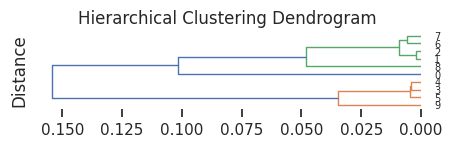

In [24]:
plot_dendrogram(Z,dense=7,line_width=1)

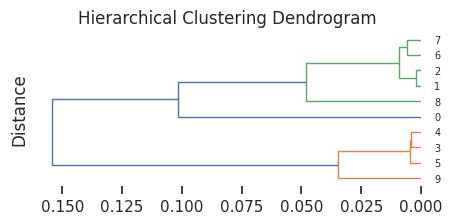

In [25]:
plot_dendrogram(Z,dense=4)

In [26]:
#| export
def pssm_to_seq(pssm_df, 
                thr=0.2, # threshold of probability to show in sequence
                clean_center=True, # if true, zero out non-last three values in position 0 (keep only s,t,y values at center)
                ):
    "Represent PSSM in string sequence of amino acids"
    
    pssm_df = pssm_df.copy()
    if clean_center:
        pssm_df.loc[pssm_df.index[:-3], 0] = 0  # keep only s,t,y in center 0 position

    pssm_df.index = pssm_df.index.map(lambda x: x.replace('pS', 's').replace('pT', 't').replace('pY', 'y'))

    consensus = []
    for i, col in enumerate(pssm_df.columns):
        # consider the case where sum for the position is 0
        column_vals = pssm_df[col]
        if column_vals.sum() == 0:
            symbol = '_'
        else:
            top = column_vals.nlargest(3)
            passing = [aa for aa, prob in zip(top.index, top.values) if prob > thr]

            if not passing:
                symbol = '.'
            elif len(passing) == 1:
                symbol = passing[0]
            else:
                symbol = f"[{'/'.join(passing)}]"
                
        if col == 0:  # center position
            if symbol.startswith('['):
                symbol = symbol[:-1] + ']*'
            else:
                symbol += '*'

        consensus.append(symbol)

    return ''.join(consensus)

In [27]:
pssm_to_seq(pssm_df,thr=0.1)

'...[E/D].[t/s]*[s/t]...'

In [28]:
#| export
def get_pssm_seq_labels(pssms,
                        count_map=None, # df index as key, counts as value
                        thr=0.3, # threshold of probability to show in sequence
                       ):
    "Use index of pssms and the pssm to seq to represent pssm."
    if count_map is not None:
        labels=[str(i)+f' (n={count_map[i]:,})' + ': '+pssm_to_seq(recover_pssm(r),thr=thr) for i,r in pssms.iterrows()]
    else:
        labels=[str(i)+ ': '+pssm_to_seq(recover_pssm(r),thr) for i,r in pssms.iterrows()]

    return labels

In [29]:
get_pssm_seq_labels(pssms.head(10))

['AAK1: .....t*G...',
 'ACVR2A: .....[t/s]*....',
 'ACVR2B: .....[t/s]*....',
 'AKT1: ..RR.[s/t]*....',
 'AKT2: ..R..[s/t]*....',
 'AKT3: ..RR.[s/t]*....',
 'ALK2: .....[t/s]*....',
 'ALK4: .....[t/s]*....',
 'ALPHAK3: .....t*....',
 'AMPKA1: .....[s/t]*....']

In [30]:
import random

In [31]:
# get a dict of index and counts

count_dict = {idx:random.randint(1,100) for idx in pssms.head(10).index}

In [32]:
labels= get_pssm_seq_labels(pssms.head(10),count_dict)
labels

['AAK1 (n=64): .....t*G...',
 'ACVR2A (n=56): .....[t/s]*....',
 'ACVR2B (n=30): .....[t/s]*....',
 'AKT1 (n=37): ..RR.[s/t]*....',
 'AKT2 (n=94): ..R..[s/t]*....',
 'AKT3 (n=68): ..RR.[s/t]*....',
 'ALK2 (n=86): .....[t/s]*....',
 'ALK4 (n=79): .....[t/s]*....',
 'ALPHAK3 (n=64): .....t*....',
 'AMPKA1 (n=88): .....[s/t]*....']

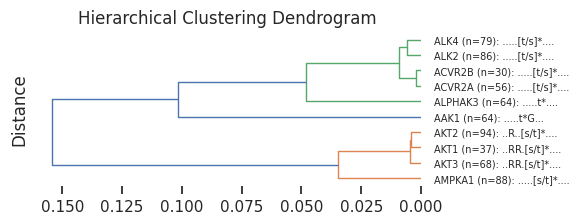

In [33]:
plot_dendrogram(Z,dense=4,labels=labels)

## Full pipeline

In [34]:
#| eval: false
# get distance matrix
pssms=pssms.head(100)

Z = get_Z(pssms)

# optional, get counts for each index
# count_dict = pssms.index.value_counts()

# get pssm to seq labels with counts
# labels= get_pssm_seq_labels(pssms,count_dict)

# or get pssm to seq labels only
labels= get_pssm_seq_labels(pssms)

  0%|          | 0/4950 [00:00<?, ?it/s]

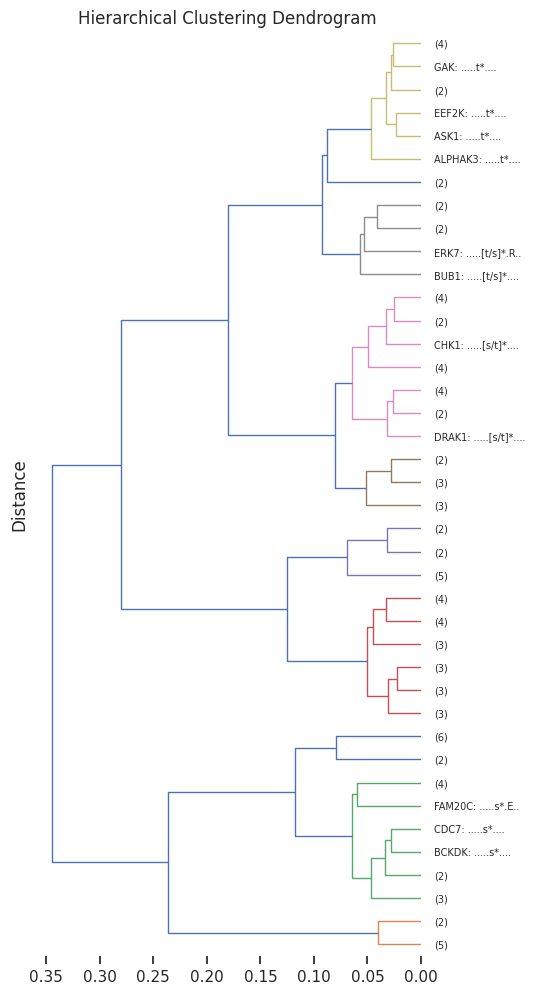

In [35]:
# plot dendrogram
plot_dendrogram(Z,dense=8,labels=labels,truncate_mode='lastp', p=40) # only show 40

# save
# save_pdf('dendrogram.pdf')

## End

In [91]:
#| hide
import nbdev; nbdev.nbdev_export()